# Imports

In [16]:
import pandas as pd
import numpy as np
import json
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, 
                              AdaBoostClassifier, BaggingClassifier, StackingClassifier)
# import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, roc_auc_score, ConfusionMatrixDisplay


from sklearn.impute import SimpleImputer

# Load Data

In [17]:
y = pd.read_csv('data/train.csv')
y

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [18]:
def update_dataset(dataset, signs, col_names):
    print(f'recordings found: {y.loc[[s in signs for s in y.sign]].shape[0]}')
    for i, sign in enumerate(signs):
        print(f'sign: {sign}, {i+1}/{len(signs)}')
        for j, participant_id in enumerate(y.participant_id.unique()):
            print(f'    pid: {j+1}/21')
            y_subset = y.loc[(y.sign == sign) & (y.participant_id == participant_id)]
            data = []
            n = y_subset.shape[0]
            for k, path in enumerate(y_subset.path):
                print(f'        recording: {k+1}/{n}')
                path_D = "D:/" + path
                df = pd.read_parquet(path_D)
                this_data = []
                for type in set(df.type):
                    df_t = df.loc[df.type == type]
                    for lm_i in set(df_t.landmark_index):
                        df_t_i = df_t.loc[(df_t['x'].notna()) & (df_t['y'].notna()) & (df_t.landmark_index == lm_i)]
                        if df_t_i.shape[0] != 0:
                            this_data.append(df_t_i.iloc[0]['x'])
                            this_data.append(df_t_i.iloc[0]['y'])
                            this_data.append(df_t_i.iloc[-1]['x'] - df_t_i.iloc[0]['x'])
                            this_data.append(df_t_i.iloc[-1]['y'] - df_t_i.iloc[0]['y'])
                        else:
                            this_data.extend([0,0,0,0])
                data.append(this_data + [sign])
            sign_df = pd.DataFrame(data, columns=col_names)
            dataset = pd.concat((dataset,sign_df), axis=0, ignore_index=True)
    return dataset

#### Signs used on round two of data collection
['pig',
 'elephant',
 'mad',
 'finger',
 'green',
 'up',
 'bad',
 'finger',
 'bye',
 'airplane',
 'mom',
 'kitty',
 'home',
 'yellow',
 'shirt',
 'talk',
 'icecream',
 'green',
 'clown',
 'lion',
 'bad',
 'thirsty',
 'elephant',
 'book',
 'shirt',
 'dog',
 'finger',
 'pretty',
 'vacuum',
 'vacuum',
 'chocolate',
 'pretty',
 'same',
 'red',
 'every',
 'feet',
 'drawer',
 'gum',
 'drop',
 'story',
 'puppy',
 'haveto',
 'book',
 'bad',
 'zebra',
 'cat',
 'cow',
 'mad',
 'dryer',
 'old',
 'clown',
 'garbage',
 'stairs',
 'cute',
 'wolf',
 'for',
 'tree',
 'stairs',
 'sick',
 'finish',
 'bird',
 'nose',
 'no',
 'drop',
 'yellow',
 'garbage',
 'have',
 'blow',
 'wet',
 'airplane',
 'vacuum',
 'no',
 'bye',
 'nose',
 'give',
 'puppy',
 'gum',
 'dry',
 'shower',
 'another',
 'every',
 'haveto',
 'wolf',
 'bee',
 'empty',
 'puppy',
 'thirsty',
 'night',
 'gum',
 'sick',
 'drawer',
 'nose',
 'have',
 'pretty',
 'airplane',
 'cry',
 'tiger',
 'mom',
 'talk',
 'have',
 'green',
 'zebra',
 'because',
 'gum',
 'puppy',
 'mad',
 'wolf',
 'donkey',
 'yes',
 'yucky',
 'why',
 'no',
 'tree',
 'tree',
 'dryer',
 'morning',
 'that',
 'orange',
 'where',
 'wolf',
 'tomorrow',
 'tomorrow',
 'gum',
 'uncle',
 'shower',
 'mouth',
 'nose',
 'farm',
 'frog',
 'table',
 'green',
 'another',
 'helicopter',
 'talk',
 'dry',
 'hear',
 'yourself',
 'cute',
 'gum',
 'garbage',
 'dryer',
 'find',
 'kitty',
 'chocolate',
 'no',
 'bird',
 'girl',
 'story',
 'red',
 'cry',
 'story',
 'yourself',
 'vacuum',
 'green',
 'another']

In [19]:
len(signs)

155

In [22]:
col_names = pd.read_csv('data/col_names.csv', index_col=0)['0']
dataset = pd.DataFrame([],columns=col_names)

dataset = update_dataset(dataset,signs,col_names)


recordings found: 31173
sign: pig, 1/155
    pid: 1/21
        recording: 1/20
        recording: 2/20
        recording: 3/20
        recording: 4/20
        recording: 5/20
        recording: 6/20
        recording: 7/20
        recording: 8/20
        recording: 9/20
        recording: 10/20
        recording: 11/20
        recording: 12/20
        recording: 13/20
        recording: 14/20
        recording: 15/20
        recording: 16/20
        recording: 17/20
        recording: 18/20
        recording: 19/20
        recording: 20/20
    pid: 2/21
        recording: 1/20
        recording: 2/20
        recording: 3/20
        recording: 4/20
        recording: 5/20
        recording: 6/20
        recording: 7/20
        recording: 8/20
        recording: 9/20
        recording: 10/20
        recording: 11/20
        recording: 12/20
        recording: 13/20
        recording: 14/20
        recording: 15/20
        recording: 16/20
        recording: 17/20
        recording: 18/20

# Load dataset to CSV

In [ ]:
dataset

0,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose,sign
0,0.144412,0.770001,-0.036422,0.060955,0.220252,0.751034,-0.007117,0.059470,0.294891,0.766529,...,0,0,0,0,0,0,0,0,0,hungry
1,0.228887,0.870846,0.149825,0.046881,0.217067,0.780410,0.173444,0.069344,0.283111,0.704707,...,0,0,0,0,0,0,0,0,0,hungry
2,0.219266,0.694923,-0.047326,0.136267,0.246657,0.630376,-0.000493,0.144555,0.315621,0.584842,...,0,0,0,0,0,0,0,0,0,hungry
3,0.265351,0.609593,-0.113243,0.169336,0.300004,0.556525,-0.051936,0.175018,0.358254,0.529226,...,0,0,0,0,0,0,0,0,0,hungry
4,0.192178,0.910085,-0.109875,0.009503,0.231285,0.847868,-0.097434,0.014697,0.305320,0.801218,...,0,0,0,0,0,0,0,0,0,hungry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,0.193068,0.923969,-0.078866,-0.004041,0.260601,0.913955,-0.079592,-0.044215,0.347179,0.921198,...,0,0,0,0,0,0,0,0,0,sad
1926,0.170649,0.570945,0.060329,0.133260,0.135809,0.521333,0.054570,0.132506,0.129563,0.472480,...,0,0,0,0,0,0,0,0,0,sad
1927,0.210017,0.639666,0.055052,0.119701,0.212688,0.587005,0.029253,0.124798,0.218489,0.539113,...,0,0,0,0,0,0,0,0,0,sad
1928,0.182864,0.313735,-0.023216,0.349968,0.249060,0.339251,-0.095147,0.272177,0.301587,0.346081,...,0,0,0,0,0,0,0,0,0,sad


In [ ]:
dataset.to_csv('data/dataset_round2_155.csv')

# LUCA Save first! (command+s), then run (sheft+enter) cell below

In [ ]:
!git add .
!git commit -m "+155 signs"
!git push

In [21]:
dataset

0,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose,sign


# Train Test Split

In [87]:
X = dataset.drop(columns='sign')
with open('data/sign_to_prediction_index_map.json') as f:
    sign_map = json.load(f)
y = dataset['sign'].map(sign_map)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1447, 2172), (483, 2172), (1447,), (483,))

In [ ]:
# template
_pipe = Pipeline(steps=[('model', ())])
_pipe.fit(X_train, y_train)
_pred = _pipe.predict(X_test)
print('Score:', _pipe.score(X_test,y_test))
print(classification_report(y_test, _pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, _pred, display_labels=signs)

# Baseline Models

## Logistic Regression

Score: 0.7494824016563147
              precision    recall  f1-score   support

      hungry       0.89      0.80      0.84        95
        stay       0.73      0.68      0.70       100
       drink       0.69      0.78      0.74        96
         dad       0.81      0.73      0.77        98
         sad       0.66      0.76      0.70        94

    accuracy                           0.75       483
   macro avg       0.76      0.75      0.75       483
weighted avg       0.76      0.75      0.75       483



c:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


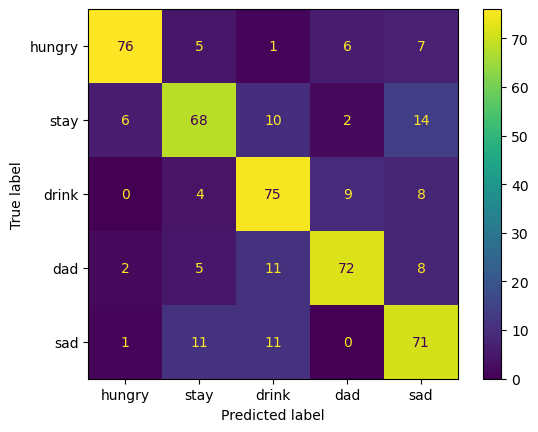

In [98]:
lr_pipe = Pipeline(steps=[('model', LogisticRegression())])
lr_pipe.fit(X_train, y_train)
lr_pred = lr_pipe.predict(X_test)
print('Mean Accuracy Score:', lr_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,lr_pred))
print(classification_report(y_test,lr_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test,lr_pred, display_labels=signs)

## KNN

Score: 0.6521739130434783
              precision    recall  f1-score   support

      hungry       0.84      0.75      0.79        95
        stay       0.57      0.65      0.60       100
       drink       0.64      0.69      0.66        96
         dad       0.67      0.65      0.66        98
         sad       0.58      0.52      0.55        94

    accuracy                           0.65       483
   macro avg       0.66      0.65      0.65       483
weighted avg       0.66      0.65      0.65       483



c:\Users\alexa\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\alexa\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

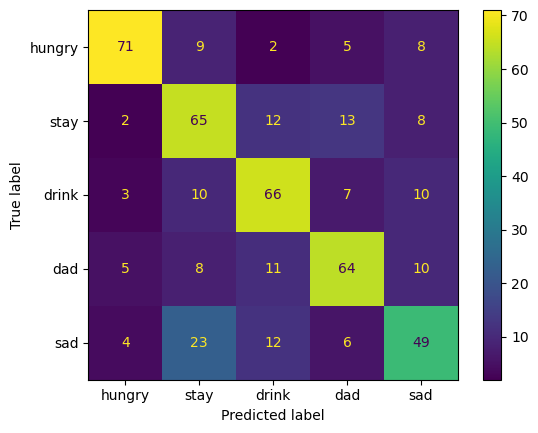

In [99]:
knn_pipe = Pipeline(steps=[('model', KNeighborsClassifier())])
knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)
print('Mean Accuracy Score:', knn_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,knn_pred))
print(classification_report(y_test,knn_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test,knn_pred, display_labels=signs)

## Bayes

Score: 0.2815734989648033
              precision    recall  f1-score   support

      hungry       0.27      0.22      0.24        95
        stay       0.26      0.56      0.36       100
       drink       0.33      0.15      0.20        96
         dad       0.31      0.21      0.25        98
         sad       0.29      0.26      0.27        94

    accuracy                           0.28       483
   macro avg       0.29      0.28      0.27       483
weighted avg       0.29      0.28      0.27       483



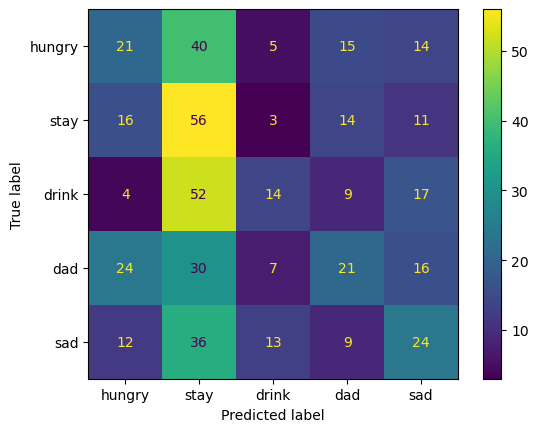

In [100]:
nb_pipe = Pipeline(steps=[('model', GaussianNB())])
nb_pipe.fit(X_train, y_train)
nb_pred = nb_pipe.predict(X_test)
print('Mean Accuracy Score:', nb_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,nb_pred))
print(classification_report(y_test,nb_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test,nb_pred, display_labels=signs)

## Decision Tree

Score: 0.6190476190476191
              precision    recall  f1-score   support

      hungry       0.69      0.73      0.71        95
        stay       0.57      0.56      0.57       100
       drink       0.67      0.69      0.68        96
         dad       0.65      0.53      0.58        98
         sad       0.52      0.60      0.56        94

    accuracy                           0.62       483
   macro avg       0.62      0.62      0.62       483
weighted avg       0.62      0.62      0.62       483



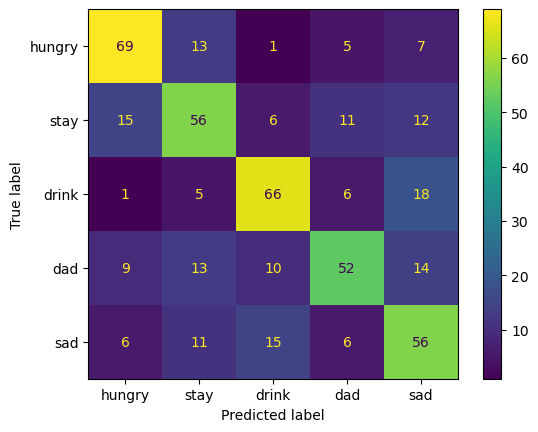

In [101]:
dt_pipe = Pipeline(steps=[('model', DecisionTreeClassifier())])
dt_pipe.fit(X_train, y_train)
dt_pred = dt_pipe.predict(X_test)
print('Mean Accuracy Score:', dt_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,dt_pred))
print(classification_report(y_test,dt_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test,dt_pred, display_labels=signs)

## Random Forest

Score: 0.7494824016563147
              precision    recall  f1-score   support

      hungry       0.86      0.82      0.84        95
        stay       0.76      0.71      0.74       100
       drink       0.70      0.81      0.75        96
         dad       0.79      0.71      0.75        98
         sad       0.66      0.69      0.67        94

    accuracy                           0.75       483
   macro avg       0.75      0.75      0.75       483
weighted avg       0.75      0.75      0.75       483



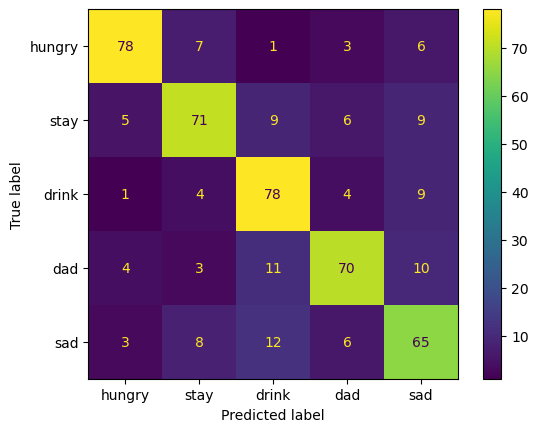

In [102]:
rf_pipe = Pipeline(steps=[('model', RandomForestClassifier())])
rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)
print('Mean Accuracy Score:', rf_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,rf_pred))
print(classification_report(y_test, rf_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, display_labels=signs)

## ExtraTreeClassifier

Score: 0.484472049689441
              precision    recall  f1-score   support

      hungry       0.57      0.64      0.60        95
        stay       0.40      0.33      0.36       100
       drink       0.60      0.64      0.62        96
         dad       0.44      0.50      0.47        98
         sad       0.38      0.32      0.34        94

    accuracy                           0.48       483
   macro avg       0.48      0.49      0.48       483
weighted avg       0.48      0.48      0.48       483



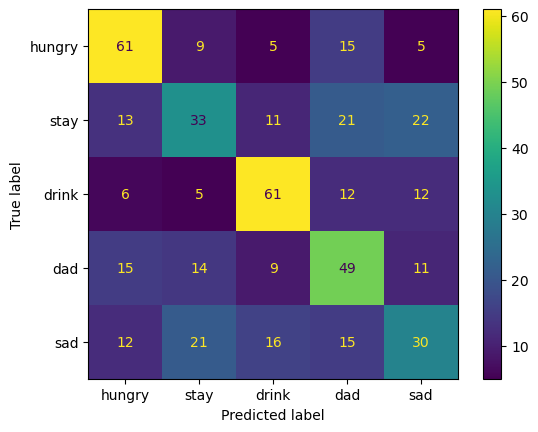

In [103]:
etc_pipe = Pipeline(steps=[('model', ExtraTreeClassifier())])
etc_pipe.fit(X_train, y_train)
etc_pred = etc_pipe.predict(X_test)
print('Mean Accuracy Score:', etc_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,etc_pred))
print(classification_report(y_test, etc_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, etc_pred, display_labels=signs)

## ExtraTreesClassifier

Score: 0.7412008281573499
              precision    recall  f1-score   support

      hungry       0.92      0.80      0.85        95
        stay       0.73      0.72      0.73       100
       drink       0.74      0.79      0.76        96
         dad       0.74      0.72      0.73        98
         sad       0.61      0.67      0.64        94

    accuracy                           0.74       483
   macro avg       0.75      0.74      0.74       483
weighted avg       0.75      0.74      0.74       483



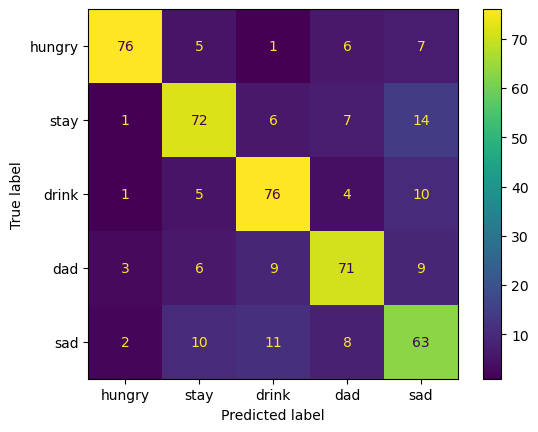

In [104]:
etcs_pipe = Pipeline(steps=[('model', ExtraTreesClassifier())])
etcs_pipe.fit(X_train, y_train)
etcs_pred = etcs_pipe.predict(X_test)
print('Mean Accuracy Score:', etcs_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,etcs_pred))
print(classification_report(y_test, etcs_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, etcs_pred, display_labels=signs)

## GradientBoostingClassifier

Score: 0.7846790890269151
              precision    recall  f1-score   support

      hungry       0.91      0.81      0.86        95
        stay       0.74      0.77      0.75       100
       drink       0.78      0.79      0.78        96
         dad       0.82      0.73      0.77        98
         sad       0.71      0.82      0.76        94

    accuracy                           0.78       483
   macro avg       0.79      0.79      0.79       483
weighted avg       0.79      0.78      0.79       483



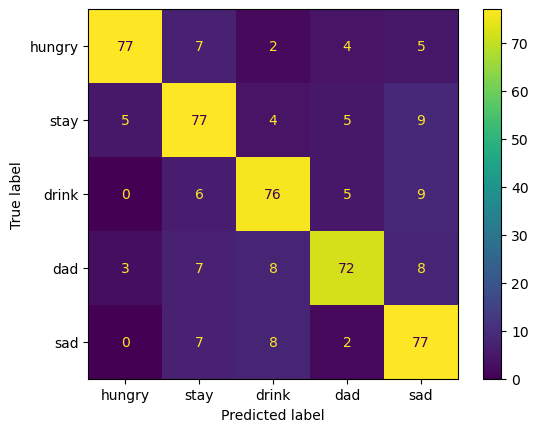

In [106]:
gb_pipe = Pipeline(steps=[('model', GradientBoostingClassifier())])
gb_pipe.fit(X_train, y_train)
gb_pred = gb_pipe.predict(X_test)
print('Mean Accuracy Score:', gb_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,gb_pred))
print(classification_report(y_test, gb_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, gb_pred, display_labels=signs)

## HistGradientBoostingClassifier


Score: 0.8074534161490683
              precision    recall  f1-score   support

      hungry       0.90      0.85      0.88        95
        stay       0.79      0.77      0.78       100
       drink       0.83      0.81      0.82        96
         dad       0.81      0.78      0.79        98
         sad       0.73      0.83      0.78        94

    accuracy                           0.81       483
   macro avg       0.81      0.81      0.81       483
weighted avg       0.81      0.81      0.81       483



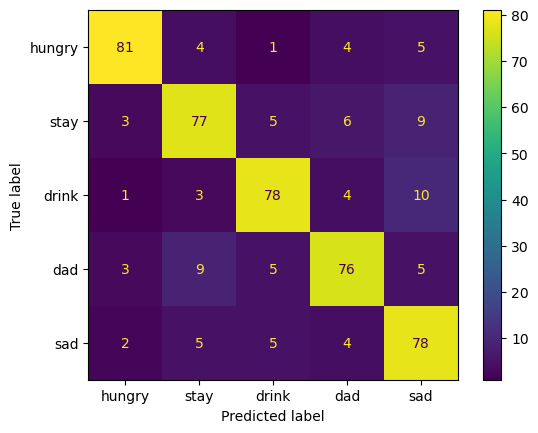

In [111]:
hgb_pipe = Pipeline(steps=[('model', HistGradientBoostingClassifier())])
hgb_pipe.fit(X_train, y_train)
hgb_pred = hgb_pipe.predict(X_test)
print('Mean Accuracy Score:', hgb_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,hgb_pred))
print(classification_report(y_test, hgb_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, hgb_pred, display_labels=signs)

## AdaBoostClassifier

Score: 0.5900621118012422
              precision    recall  f1-score   support

      hungry       0.70      0.56      0.62        95
        stay       0.46      0.63      0.53       100
       drink       0.71      0.66      0.68        96
         dad       0.64      0.59      0.62        98
         sad       0.53      0.51      0.52        94

    accuracy                           0.59       483
   macro avg       0.61      0.59      0.59       483
weighted avg       0.61      0.59      0.59       483



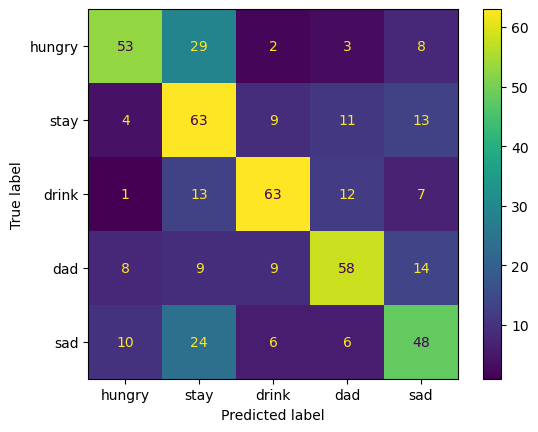

In [107]:
ada_pipe = Pipeline(steps=[('model', AdaBoostClassifier())])
ada_pipe.fit(X_train, y_train)
ada_pred = ada_pipe.predict(X_test)
print('Mean Accuracy Score:', ada_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,ada_pred))
print(classification_report(y_test, ada_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, ada_pred, display_labels=signs)

## BaggingClassifier

c:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alexa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Score: 0.7598343685300207
              precision    recall  f1-score   support

      hungry       0.89      0.79      0.84        95
        stay       0.75      0.65      0.70       100
       drink       0.71      0.82      0.76        96
         dad       0.81      0.79      0.80        98
         sad       0.68      0.76      0.71        94

    accuracy                           0.76       483
   macro avg       0.77      0.76      0.76       483
weighted avg       0.77      0.76      0.76       483



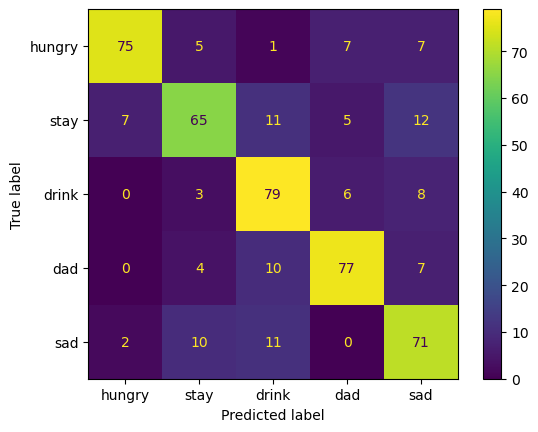

In [114]:
bag_pipe = Pipeline(steps=[('model', BaggingClassifier(base_estimator=lr_pipe))])
bag_pipe.fit(X_train, y_train)
bag_pred = bag_pipe.predict(X_test)
print('Mean Accuracy Score:', bag_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,bag_pred))
print(classification_report(y_test, bag_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, bag_pred, display_labels=signs)

## StackingClassifier

In [ ]:
# template
stack_pipe = Pipeline(steps=[('model', StackingClassifier(estimators=))])
stack_pipe.fit(X_train, y_train)
stack_pred = stack_pipe.predict(X_test)
print('Mean Accuracy Score:', stack_pipe.score(X_test,y_test))
print('ROC_AUC Score:', roc_auc_score(y_test,stack_pred))
print(classification_report(y_test, stack_pred, target_names=signs))
ConfusionMatrixDisplay.from_predictions(y_test, stack_pred, display_labels=signs)

# Baseline Model Results

In [132]:
def precision_score_(y,p): return precision_score(y,p,average='weighted')
def recall_score_(y,p): return recall_score(y,p,average='weighted')
metrics = [accuracy_score, precision_score_, recall_score_]
base_model_names = ['LR','KNN','Bayes','DT','RF','ExtC','ExtreesC','GB','HGB','AdaBoost','Bag']
preds = [lr_pred,knn_pred,nb_pred,dt_pred,rf_pred,etc_pred,etcs_pred,gb_pred,hgb_pred,ada_pred,bag_pred]
base_df = pd.DataFrame([{str(metric) : [metric(y_test,pred) for pred in preds]} for metric in metrics], columns=base_model_names)
base_df

,LR,KNN,Bayes,DT,RF,ExtC,ExtreesC,GB,HGB,AdaBoost,Bag
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
